# Rain Estimation

## Import libraries

In [58]:
from sklearn import svm   
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [59]:
complete_df = pd.read_csv("/home/gab/projetos/machine-learning/rain-estimation/Dados_Radar_Estacao_Completo_2018_2022.csv")
complete_df

,Unnamed: 0,azimuth,range,time,elevation,sweep,UH,UV,DBZH,DBZV,...,y,z,lat,lon,alt,Est,Tp_est,latitude,longitude,distancia
0,0,10,220250,2018-01-09 12:30:00,0.5,0,NaN,NaN,NaN,NaN,...,216798.04,4775.95,-22.919829,-53.156094,4895.951230,Loanda,0.0,-22.92,-53.15,219
1,1,15,73750,2018-01-09 12:30:00,0.5,0,-8.03,NaN,-9.92,NaN,...,71227.13,963.36,-24.229322,-53.341064,1083.357738,Porto_Formosa,0.0,-24.23,-53.33,74
2,2,29,226750,2018-01-09 12:30:00,0.5,0,6.00,5.17,4.74,3.38,...,198219.24,5003.38,-23.083564,-52.455313,5123.382761,Paranavai,0.2,-23.09,-52.44,230
3,3,52,144750,2018-01-09 12:30:00,0.5,0,NaN,NaN,NaN,NaN,...,89091.74,2496.08,-24.064595,-52.406170,2616.080788,Campo_Mourao,0.0,-24.07,-52.40,152
4,4,57,66750,2018-01-09 12:30:00,0.5,0,NaN,-8.08,NaN,NaN,...,36350.03,844.52,-24.542079,-52.975897,964.515047,Ubirata,0.0,-24.55,-52.97,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856374,2856374,149,121500,2022-12-22 12:45:00,0.5,0,4.77,4.75,3.81,4.09,...,-104121.77,1928.94,-25.805085,-52.904342,2048.943578,Bela_Vista_Jusante,0.0,-25.81,-52.91,124
2856375,2856375,176,73500,2022-12-22 12:45:00,0.5,0,0.00,-1.49,-1.73,-2.94,...,-73310.80,959.20,-25.529292,-53.478188,1079.201517,Reservatorio_Salto_Caxias,0.0,-25.53,-53.48,73
2856376,2856376,297,21500,2022-12-22 12:45:00,0.5,0,27.52,30.50,NaN,NaN,...,9760.19,214.65,-24.782105,-53.719021,334.650059,Toledo,0.0,-24.78,-53.72,23
2856377,2856377,320,115500,2022-12-22 12:45:00,0.5,0,3.77,4.00,2.45,2.17,...,88458.82,1792.68,-24.072698,-54.260372,1912.675465,Guaira,0.0,-24.07,-54.26,119


## Data treatment

In [60]:
# remove unnecessary columns
clean_df = complete_df.copy()
clean_df.drop(columns=['Unnamed: 0', 'range', 'sweep', 'Est', 'x', 'y', 'z', 'lat',	'lon', 'alt', 'latitude', 'longitude', 'distancia'], inplace=True)
clean_df = clean_df[clean_df['Tp_est'] != 0]
clean_df

,azimuth,time,elevation,UH,UV,DBZH,DBZV,KDP,ZDR,RHOHV,Tp_est
2,29,2018-01-09 12:30:00,0.5,6.00,5.17,4.74,3.38,1.84,1.33,0.68,0.2
21,29,2018-01-09 13:00:00,0.5,NaN,NaN,NaN,NaN,NaN,0.09,0.55,0.2
40,29,2018-01-09 13:30:00,0.5,NaN,NaN,NaN,NaN,NaN,1.28,0.49,0.2
59,29,2018-01-09 14:00:00,0.5,5.32,5.60,2.11,1.82,0.25,0.22,0.73,0.2
76,10,2018-01-09 14:30:00,0.5,NaN,NaN,NaN,NaN,NaN,0.22,0.46,0.8
...,...,...,...,...,...,...,...,...,...,...,...
2854605,126,2022-12-20 21:15:00,0.5,NaN,NaN,NaN,NaN,NaN,4.45,0.41,2.8
2854624,126,2022-12-20 21:30:00,0.5,NaN,NaN,NaN,NaN,NaN,-1.06,0.39,0.2
2854643,126,2022-12-20 21:45:00,0.5,NaN,NaN,NaN,NaN,NaN,0.50,0.21,0.2
2854657,15,2022-12-20 22:00:00,0.5,NaN,NaN,NaN,NaN,NaN,3.10,0.51,0.2


In [61]:
# split data into train and test
train = clean_df.copy()
train = train[train['time'] < '2022-01-01']
train.drop(['time'], axis=1, inplace=True)

test = clean_df.copy()
test = test[test['time'] >= '2022-01-01']
test.drop(['time'], axis=1, inplace=True)

len(test), len(train)

(26244, 88928)

In [62]:
# replace Nan values with mean of nearest values
train = train.fillna(method='ffill')
train

,azimuth,elevation,UH,UV,DBZH,DBZV,KDP,ZDR,RHOHV,Tp_est
2,29,0.5,6.00,5.17,4.74,3.38,1.84,1.33,0.68,0.2
21,29,0.5,6.00,5.17,4.74,3.38,1.84,0.09,0.55,0.2
40,29,0.5,6.00,5.17,4.74,3.38,1.84,1.28,0.49,0.2
59,29,0.5,5.32,5.60,2.11,1.82,0.25,0.22,0.73,0.2
76,10,0.5,5.32,5.60,2.11,1.82,0.25,0.22,0.46,0.8
...,...,...,...,...,...,...,...,...,...,...
2461478,10,0.5,10.58,9.15,9.46,8.64,0.32,1.92,0.65,1.2
2461497,10,0.5,10.98,12.63,9.30,9.96,0.09,-1.15,0.68,0.4
2461499,29,0.5,10.86,11.35,9.19,9.97,0.65,0.01,0.72,0.6
2461822,29,0.5,10.86,11.35,9.19,9.97,0.65,0.50,0.30,0.2


## Data distribution treatment

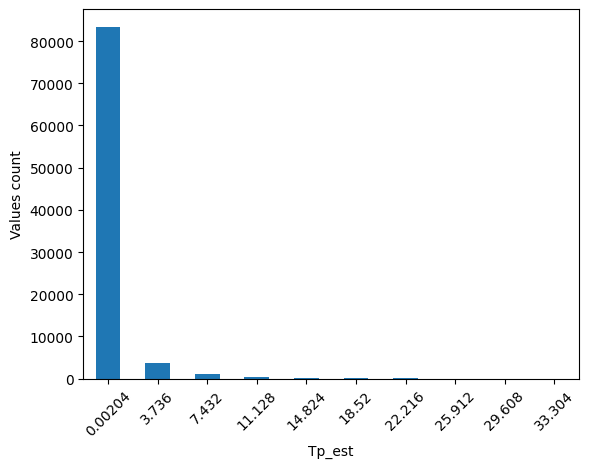

In [63]:
def visualize(df, column):
    # count column values into bins
    count = df[column].value_counts(bins=10)
    count.index = count.index.astype(str)
    count.index = count.index.str.split(',').str[0].str.replace('(', '')
    count.plot(kind='bar')
    plt.xticks(rotation=45)
    plt.ylabel('Values count')
    plt.show()

visualize(train, 'Tp_est')


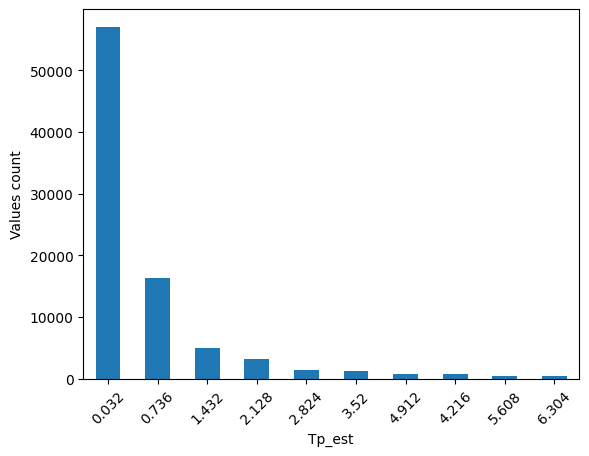

In [64]:
# remove outliers
train = train[(np.abs(stats.zscore(train['Tp_est'])) < 3)]
visualize(train, 'Tp_est')

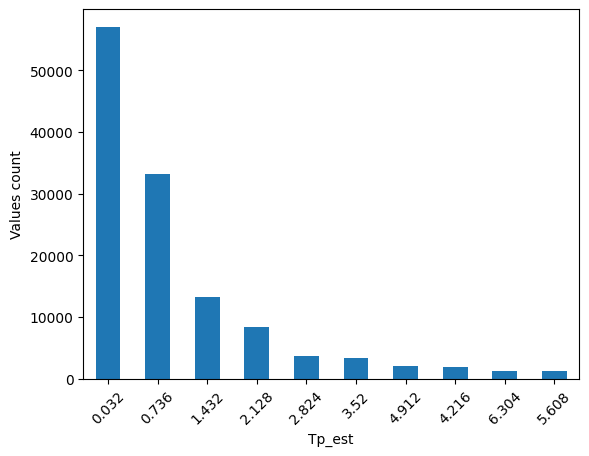

In [65]:
# oversample minority class
train_majority = train[train['Tp_est'] < 1]
train_minority = train[train['Tp_est'] >= 1]

train_minority_upsampled = resample(train_minority,
                                    replace=True,
                                    n_samples=len(train_majority*10),
                                    random_state=123)

train_oversampled = pd.concat([train_majority, train_minority_upsampled])
visualize(train_oversampled, 'Tp_est')

## Train SVM

In [66]:
x_train = train_oversampled.drop(['Tp_est'], axis=1)
y_train = train_oversampled['Tp_est']

regr = make_pipeline(StandardScaler(), svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1, verbose=True))
regr.fit(x_train, y_train)

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
import joblib
from datetime import datetime
joblib.dump(regr, f"rain-estimation-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pkl", compress=True)

['rain-estimation-2023-10-06-20-18-59.pkl']

## Test SVM

MSE: 4.275344568802942
MAE: 1.0155298969161504


Text(0, 0.5, 'Prediction')

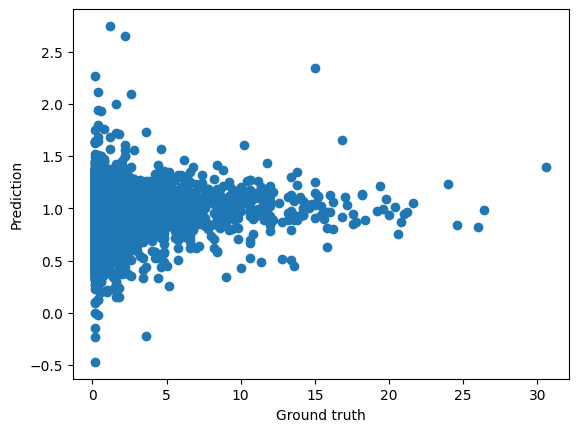

In [ ]:
x_test = test.dropna().drop(['Tp_est'], axis=1)
y_test = test.dropna()['Tp_est']

y_pred = regr.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

plt.scatter(y_test, y_pred)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')